# Simulaciones de trayectorías (plásticos)


## Introduccion

Understanding the trajectories in the Ocean is important for several applications such as marine pollution from plastics, but also for other ocean pollutants like oil spills or for marine ecology studies to understand the connectivity of marine species.  Lagrangian simulations are a powerful to obtaine marine trajectories. One of the open software tools that exist is OceanParcels.  Using as input velocity fields, such as the ones we saw in the previous tutorial (e.g. satellite altimetry gridded products of the sea surface), we can easily obtain particle trajectories with different characteristics.

<!-- Here will look at an example of a Lagrangian simulation..... -->

Want to know more details about OceanParcels? Checkout: https://docs.oceanparcels.org/en/latest/index.html


También puede explorar el simulador en línea [plastic adrift](https://plasticadrift.org/)!!

## ¿Cómo funciona?

### Características de la simulación:
* Duración (runtime): 30 días
* Número de partículas: 144 (1 por punto de malla en nuestra subregión de estudio)

In [ ]:
%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import xarray as xr
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


# Input fields:

Usaremos los campos de velocidad de .. We will use the L4 dataset again.

In [ ]:
filedir = '../content/drive/MyDrive/Altimetry/L4/'

## Primero cargamos un fichero de ejemplo::

In [ ]:
ds_m = xr.open_dataset(filedir + "dt_europe_allsat_phy_l4_20230203_20231013.nc")

In [ ]:
ds_m

<xarray.Dataset> Size: 17MB
Dimensions:         (time: 1, latitude: 370, nv: 2, longitude: 578)
Coordinates:
  * time            (time) datetime64[ns] 8B 2023-02-03
  * latitude        (latitude) float32 1kB 19.94 20.06 20.19 ... 65.94 66.06
  * longitude       (longitude) float32 2kB -30.06 -29.94 -29.81 ... 41.94 42.06
  * nv              (nv) int32 8B 0 1
Data variables: (12/14)
    crs             int32 4B ...
    lat_bnds        (latitude, nv) float32 3kB ...
    lon_bnds        (longitude, nv) float32 5kB ...
    sla             (time, latitude, longitude) float64 2MB ...
    err_sla         (time, latitude, longitude) float64 2MB ...
    ugosa           (time, latitude, longitude) float64 2MB ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 2MB ...
    adt             (time, latitude, longitude) float64 2MB ...
    ugos            (time, latitude, longitude) float64 2MB ...
    vgos            (time, latitude, longitude) float64 2MB ...
    tpa_correction  (time) float64 8B ...
    flag_ice        (time, latitude, longitude) float64 2MB ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2023-02-03T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2023-02-02T12:00:00Z
    title:                           DT merged all satellites European Seas G...

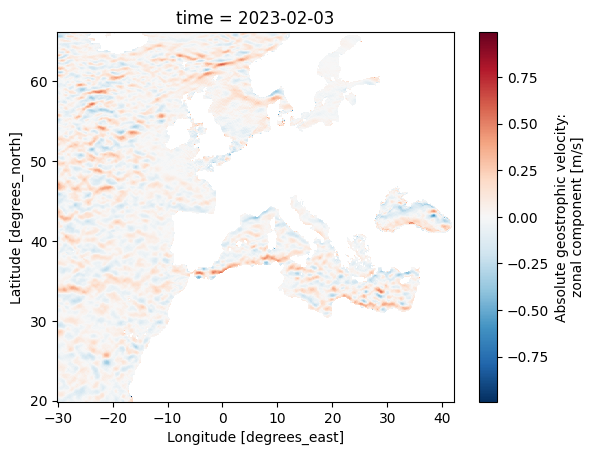

In [ ]:
ds_m.ugos[0,:,:].plot()

In [ ]:
ds_m_wmed = ds_m.where((ds_m.longitude<8)&(ds_m.longitude>0)&(ds_m.latitude<42)&(ds_m.latitude>36.), drop=True)


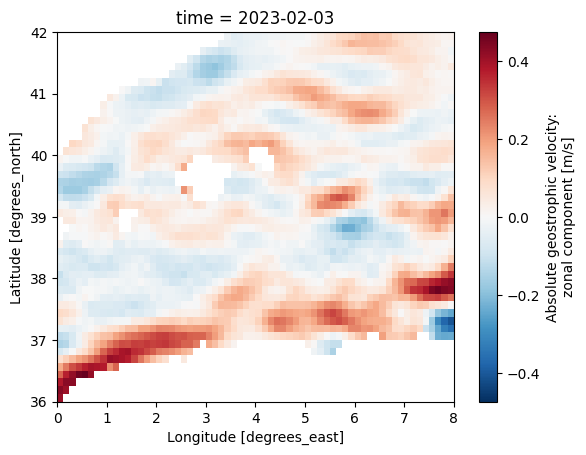

In [ ]:
ds_m_wmed.ugos[0,:,:].plot()

## Cargamos el "fieldset" (campo de velocidad) para las simulaciones:

In [ ]:
filenames = {'U': filedir + "dt_europe_allsat_phy_l4_2023020[1-9]_20231013.nc",
             'V': filedir + "dt_europe_allsat_phy_l4_2023020[1-9]_20231013.nc"}



### Usamos la velocidad euleriana, así que elegimos las variables ugos y vgos:

In [ ]:
variables = {'U': 'ugos',
             'V': 'vgos'}

dimensions = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [ ]:
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, deferred_load=False)

# Definimos los parámetros de la simulación:

## ¿Cuántas y dónde queremos lanzar las partículas?

### Opción A) Definimos las longitudes y latitudes.
### Por ejemple, lanzamos las partículas sobre una línea:

In [1]:
lat1D = np.arange(37.5, 39.1, .1) # (inicio, fin + incremento, incremento)
lon1D = np.ones_like(lat1D) * 4.

pset_A = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon1D, lat=lat1D)


NameError: name 'np' is not defined

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


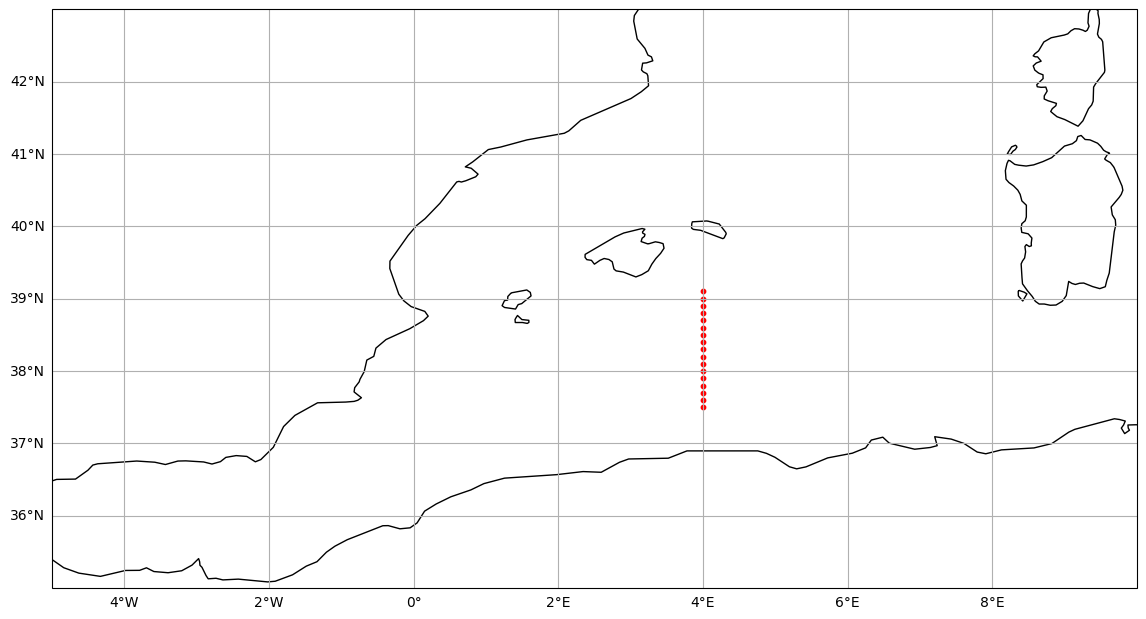

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.scatter(pset_A.lon, pset_A.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-5, 10])
ax1.set_ylim([35, 43])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### Option B) Releasing 1 particle per fieldset grid point


In [ ]:
lon1D = fieldset.U.lon[np.arange(260, 270, 1)]
lat1D = fieldset.U.lat[np.arange(140, 150, 1)]

lons, lats = np.meshgrid(lon1D, lat1D)
pset_B = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)


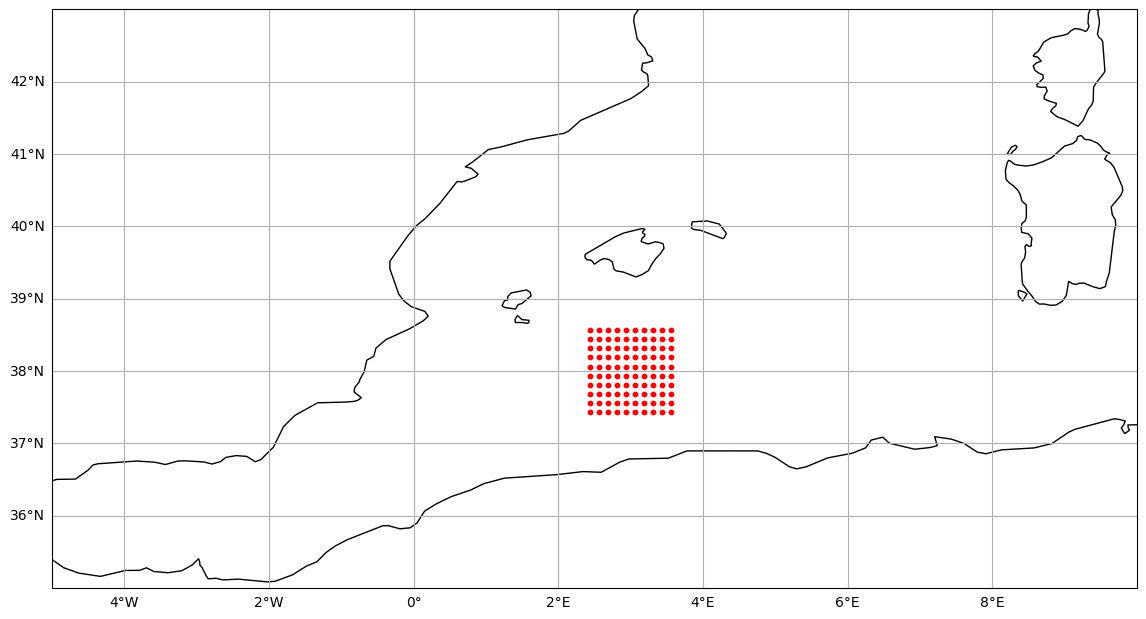

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(pset_B.lon, pset_B.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-5, 10])
ax1.set_ylim([35, 43])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Other parameters:

In [ ]:
runtime_days = 5

In [ ]:
output_filename = "lag_simu_pset_A_test01.zarr"

In [ ]:

output_file = pset_A.ParticleFile(name=output_filename, outputdt=timedelta(hours=24))
pset_A.execute(pset_A.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Output files are stored in lag_simu_pset_A_test01.zarr.


INFO:parcels.tools.loggers:Output files are stored in lag_simu_pset_A_test01.zarr.


100%|██████████| 432000.0/432000.0 [00:00<00:00, 614451.46it/s]


# Let's look at the outputs:

In [ ]:
ds = xr.open_dataset(output_filename)

/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/xarray/backends/plugins.py:149: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [ ]:
ds

<xarray.Dataset> Size: 2kB
Dimensions:     (trajectory: 17, obs: 5)
Coordinates:
  * obs         (obs) int32 20B 0 1 2 3 4
  * trajectory  (trajectory) int64 136B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
Data variables:
    lat         (trajectory, obs) float32 340B ...
    lon         (trajectory, obs) float32 340B ...
    time        (trajectory, obs) datetime64[ns] 680B ...
    z           (trajectory, obs) float32 340B ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4
    parcels_mesh:           spherical
    parcels_version:        3.0.6

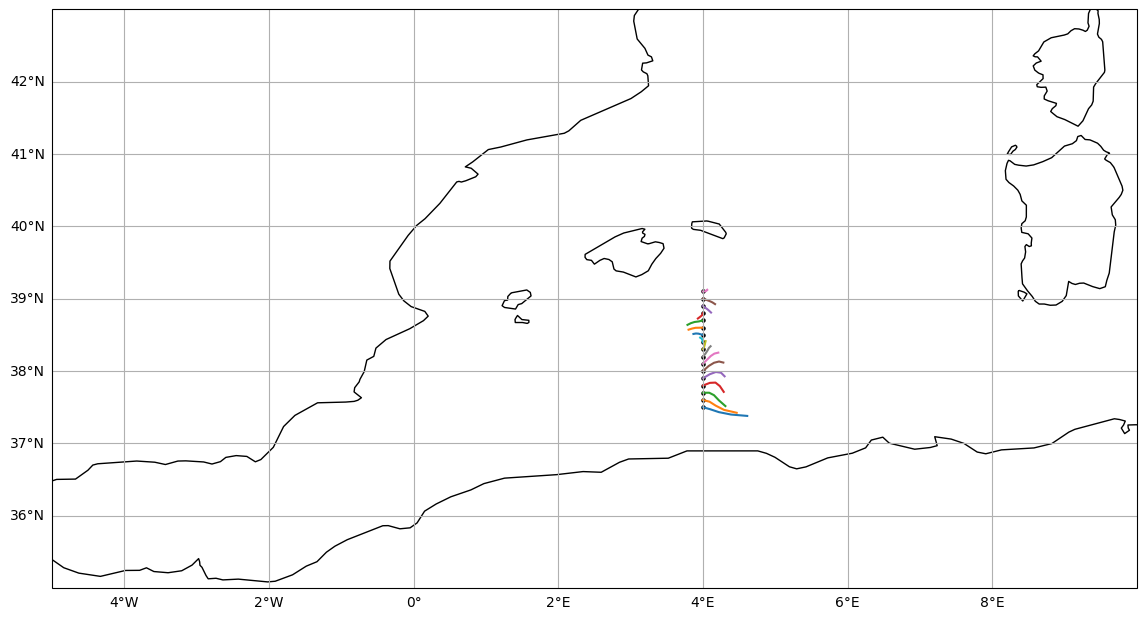

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-5, 10])
ax1.set_ylim([35, 43])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Plotting the particles in the last time-step with zonal velocity in the background:

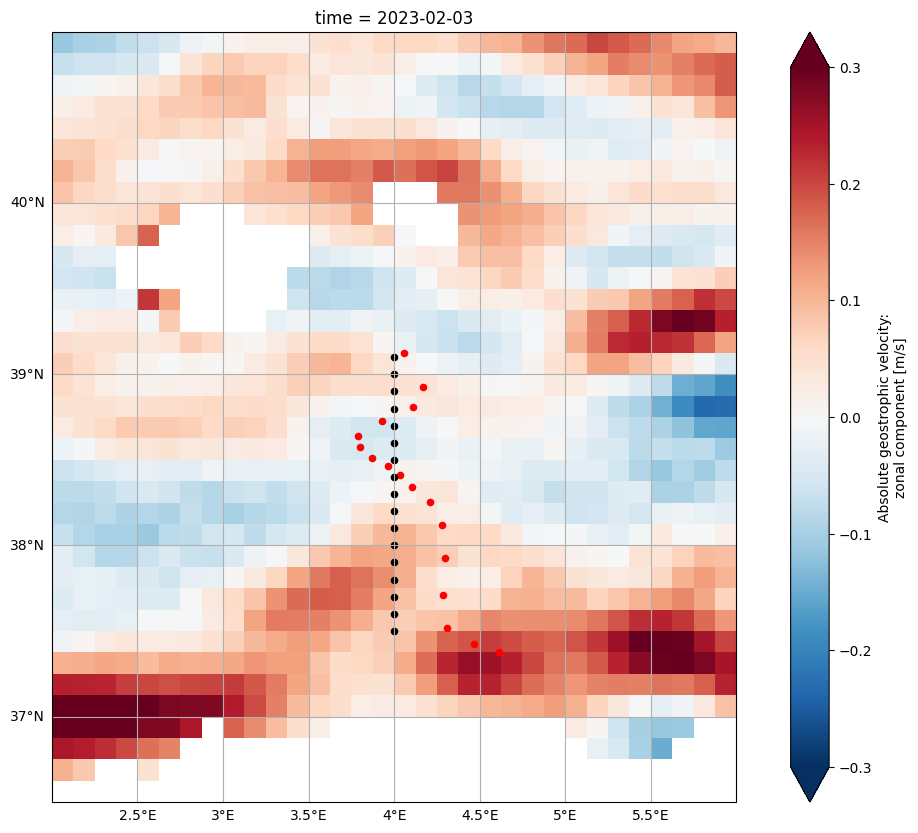

In [ ]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ds_m.ugos[0,:,:].plot(vmin=-.3, vmax=.3, cmap='RdBu_r')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=20, transform=ccrs.PlateCarree(), label='End')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=20, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([2, 6])
ax1.set_ylim([36.5, 41])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Referencias

Laura Gomez-Navarro, & Paul Hargous. (2024). IMEDEA-AP-LAB/MASS24_Altimetry_tutorial: v1.0.0 (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.13962687